In [1]:
using LombScargle # Computing Lomb-Scargle periodogram, duh
using Optim # Optimization of functions
using PyCall # Package to call Python functions from the Julia language
using PyPlot # Plotting for Julia based on `matplotlib.pyplot`
using Statistics # Basic statistics functionality
using Stheno # Probabilistic programming with Gaussian processes
using Zygote # Automatic calculation of gradients

In [2]:
kplr = pyimport("kplr")

# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attach the `kplr` API
client = kplr.API()

# Get the data
star = client.star(KIC_ID)

# Time values
tₐ = Vector{Float64}()

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
fₐ = Vector{Float32}()

# The 1-sigma errors in PDC flux values
fσₐ = Vector{Float32}()

# Get the long cadence data of the light curves
for lc in star.get_light_curves(short_cadence = false)

    # Read the data from a light curve
    data = lc.read()
    
    t₀ = get(data, "TIME")
    f₀ = get(data, "PDCSAP_FLUX")
    fσ₀ = get(data, "PDCSAP_FLUX_ERR")

    # Create a mask for only qualitative data points
    mask = (get(data, "SAP_QUALITY") .== 0) .& isfinite.(t₀) .& isfinite.(f₀)
    
    append!(tₐ, t₀[mask])
    append!(fₐ, f₀[mask])
    append!(fσₐ, fσ₀[mask])

end

In [3]:
# Get access to rcParams
rcP = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

# Set DPI
rcP["figure.dpi"] = 300

# Activate TeX support
rcP["text.usetex"] = true

# Activate languages support
rcP["text.latex.preamble"] = raw"\usepackage[main=english]{babel}"

# Switch to Computer Modern font set
rcP["mathtext.fontset"] = "cm"

# Set font sizes
rcP["font.size"] = 18
rcP["legend.fontsize"] = 12;

# Set the primary color
color = "#425378";

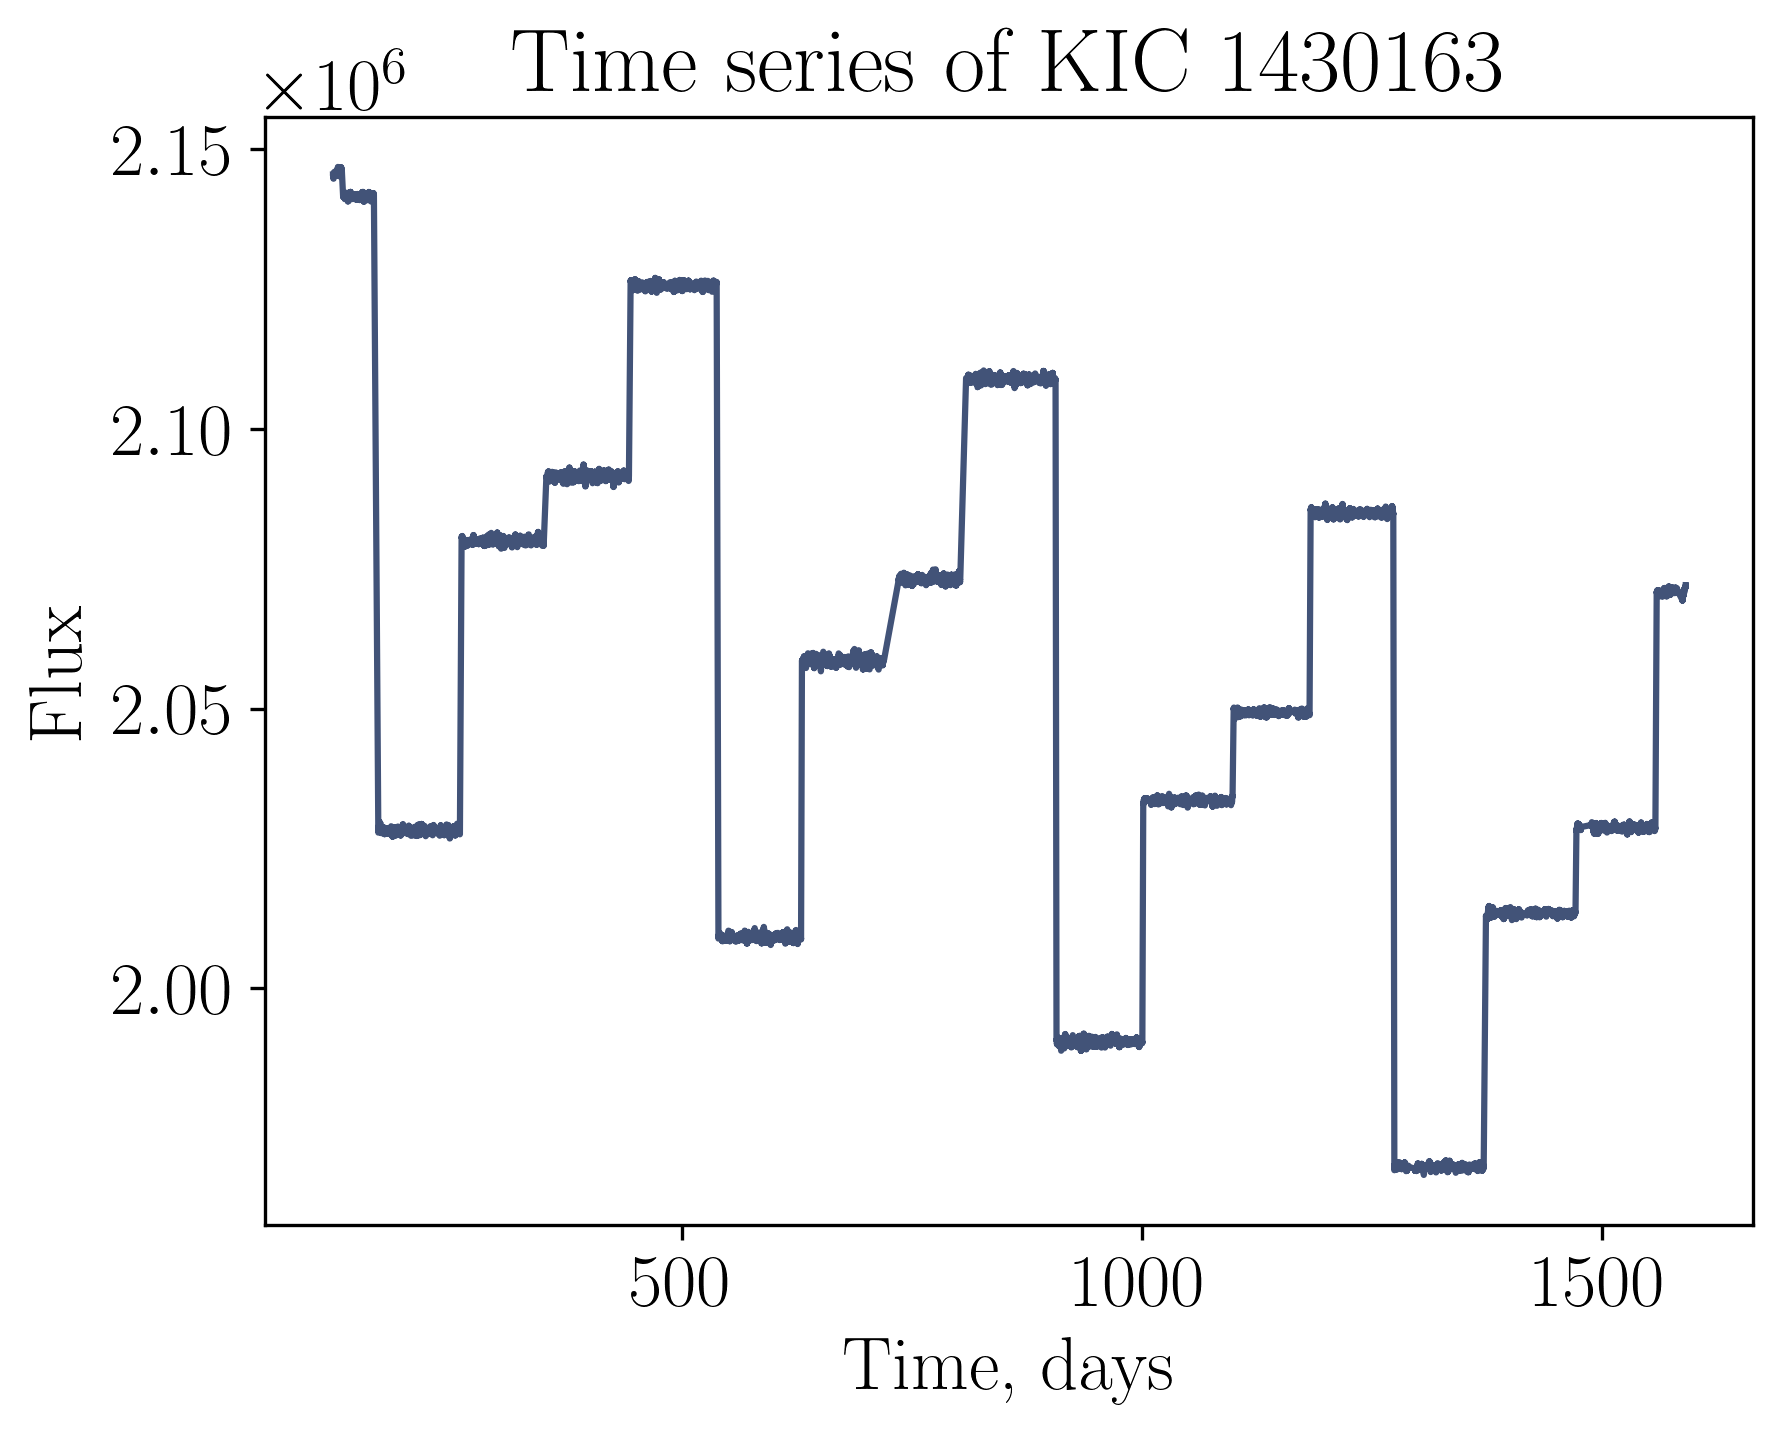

In [4]:
plot(tₐ, fₐ, color)

xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")
title(latexstring("\\textrm{Time series of KIC $KIC_ID}"));

In [5]:
# Create a mask to select one of successive periods of observation
mask = (tₐ .≥ 443.5105) .& (tₐ .≤ 537.5502295)

# Use the mask
tₘ = tₐ[mask]
const t = tₘ .- mean(tₘ)
const f = fₐ[mask]
const fσ = fσₐ[mask]

# An auxiliary variable for the general shift of text output to the left
pad = 30

println(rpad("General info:", pad))
println(rpad("Size of the subset:", pad), size(t, 1))

const μ₀ = mean(f)
println(rpad("Mean of the flux: ", pad), μ₀)

const A₀ = var(f)
println(rpad("Variance of the flux: ", pad), A₀)

const σ²ₑ = var(fσ)
println(rpad("Variance of the errors: ", pad), σ²ₑ)

# Calculating the mean of the time differences between observations
Δt = []
for i in range(2, size(t, 1), step = 1)
    push!(Δt, t[i] - t[i-1])
end
Δμ = sum(Δt) / size(Δt, 1)

println(rpad("Mean of the time differences:", pad), Δμ)

General info:                 
Size of the subset:           3518
Mean of the flux:             2.125678e6
Variance of the flux:         209401.3
Variance of the errors:       0.0028263223
Mean of the time differences: 0.026616617260856176


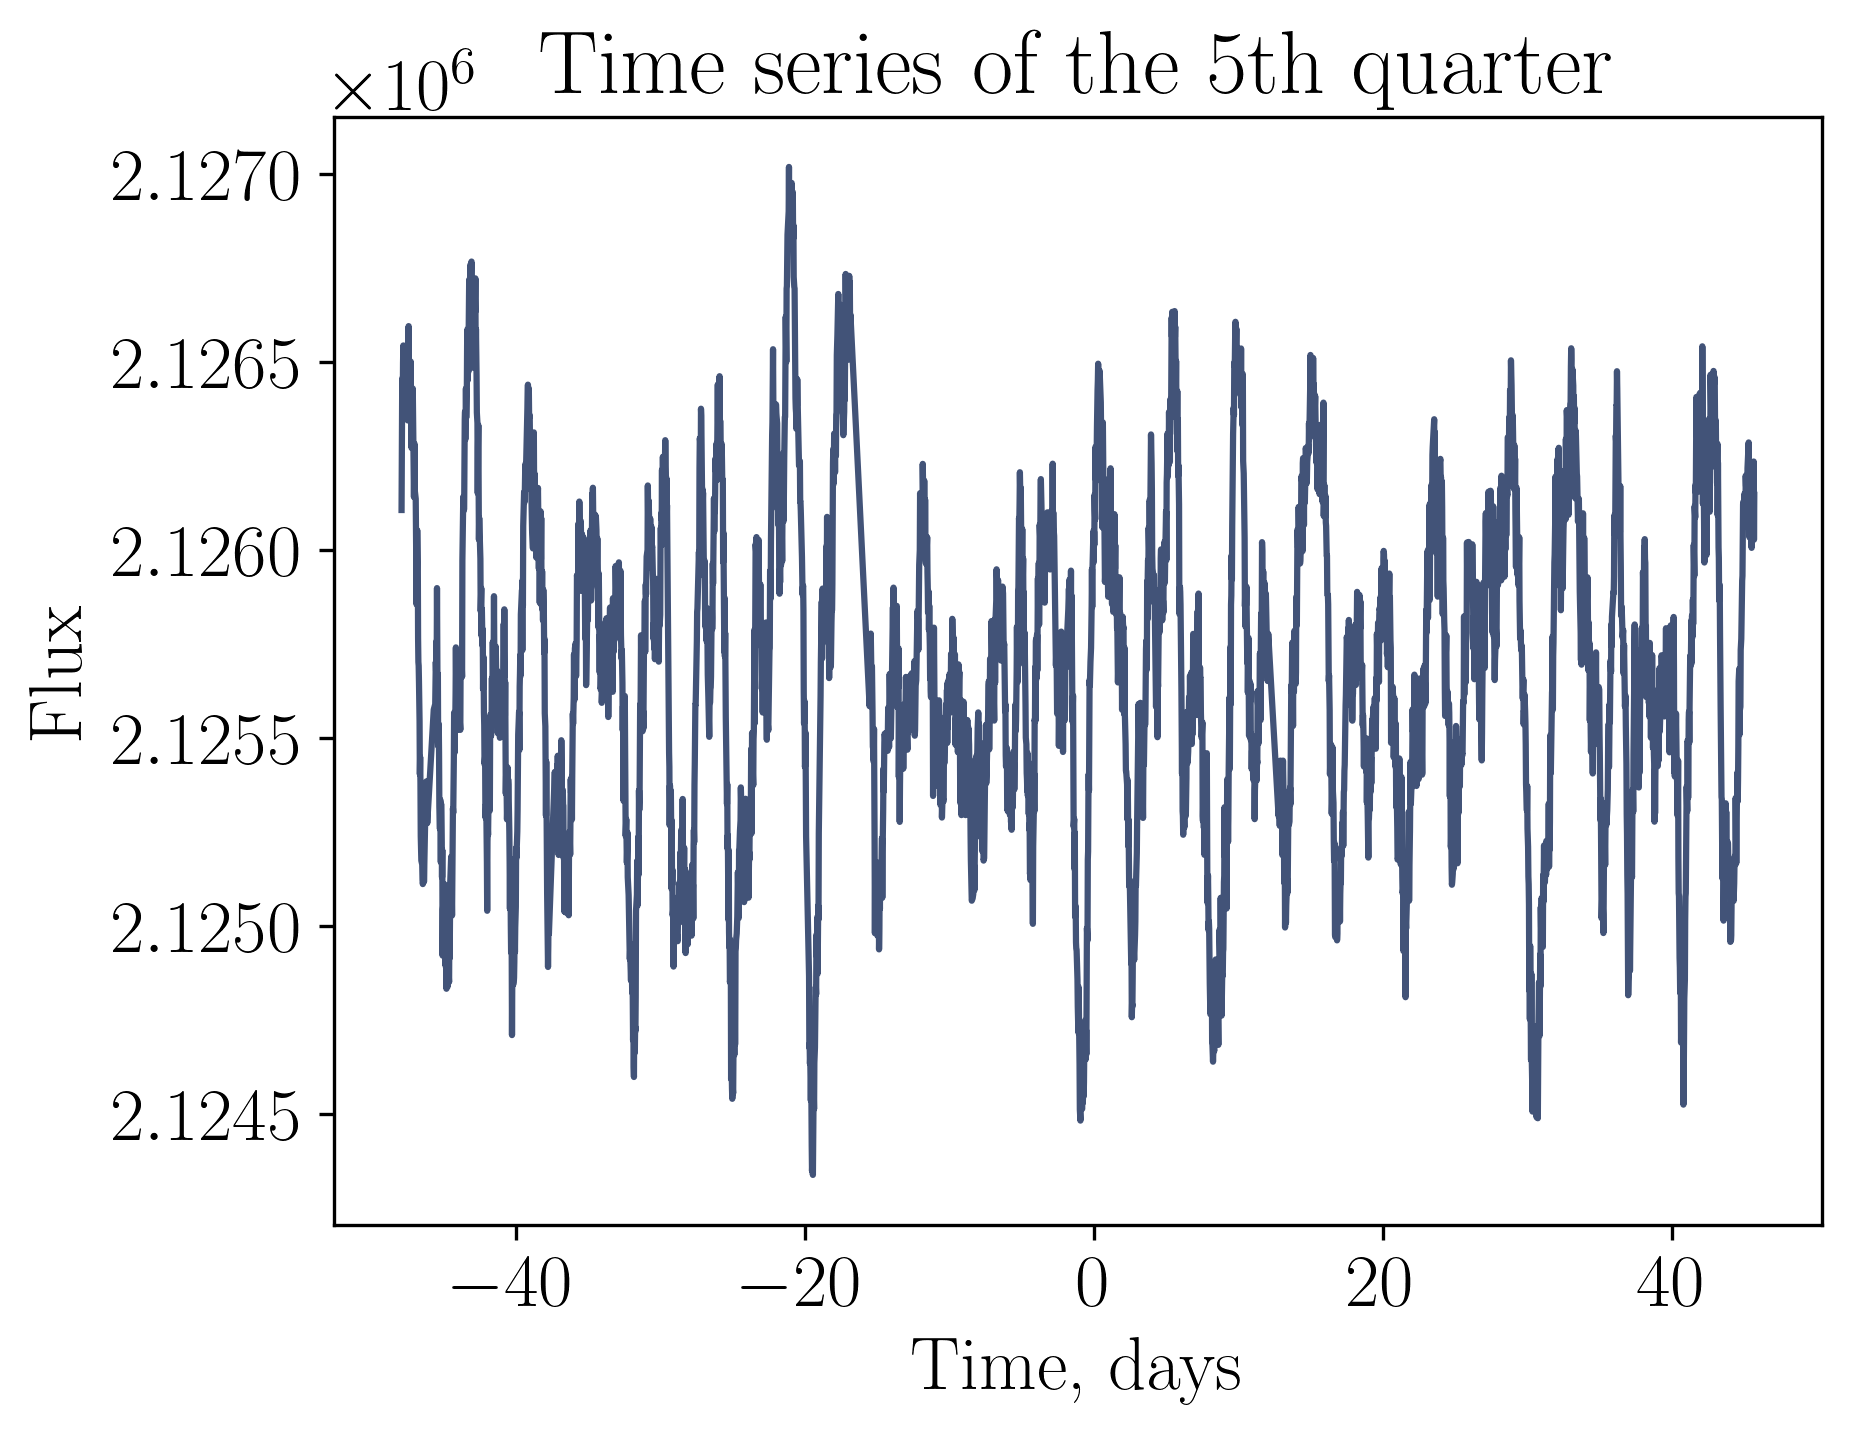

In [6]:
close()
plot(t, f, color)

xlabel(L"\textrm{Time, days}")
ylabel(L"\textrm{Flux}")
title(L"\textrm{Time series of the 5th quarter}");

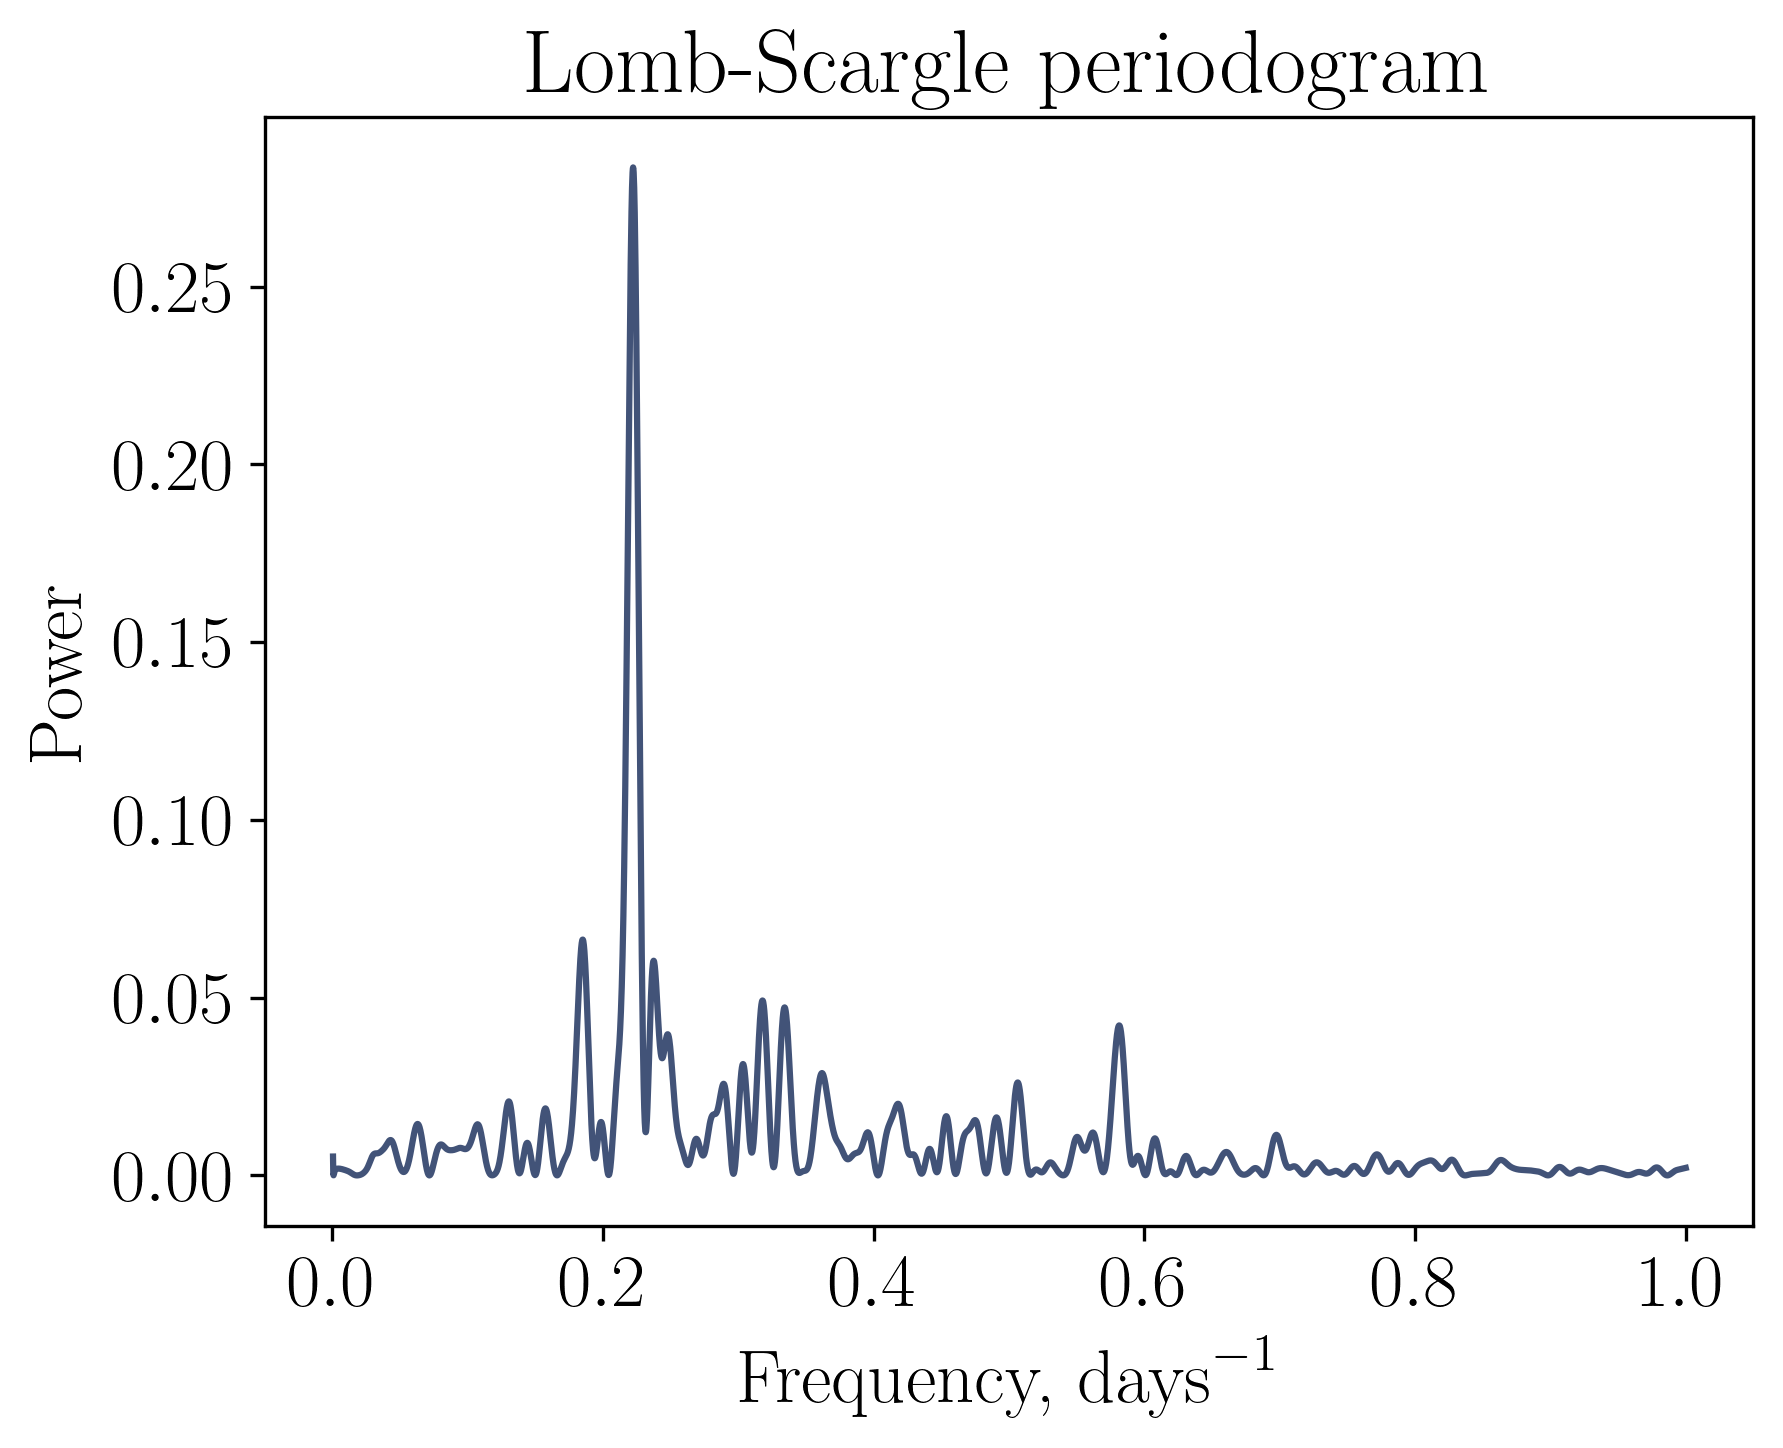

Lomb–Scargle periodogram:
The peak is at 0.2222990081813975.
The relevant estimate of the period is 4.498445621421726.


In [7]:
# Choose a set of frequencies
frequencies = range(1 / size(t, 1) + 0.0003, 1.0; length = 5000)

# Pre-plan the Lomb–Scargle periodogram
plan = LombScargle.plan(t, f, fσ; frequencies)

# Compute the Lomb–Scargle periodogram
p = lombscargle(plan)

# Get the frequency and the power vectors
ν, P = freqpower(p)

# Determine the peak
νₘ = findmaxfreq(p)[1]

# Determine the period at this peak
P₀ = 1 / νₘ

close()
plot(ν, P; color)

title(L"\textrm{Lomb-Scargle periodogram}")
xlabel(L"\textrm{Frequency, days}^{-1}")
ylabel(L"\textrm{Power}")

println("""
Lomb–Scargle periodogram:
The peak is at $(νₘ).
The relevant estimate of the period is $(P₀).""")

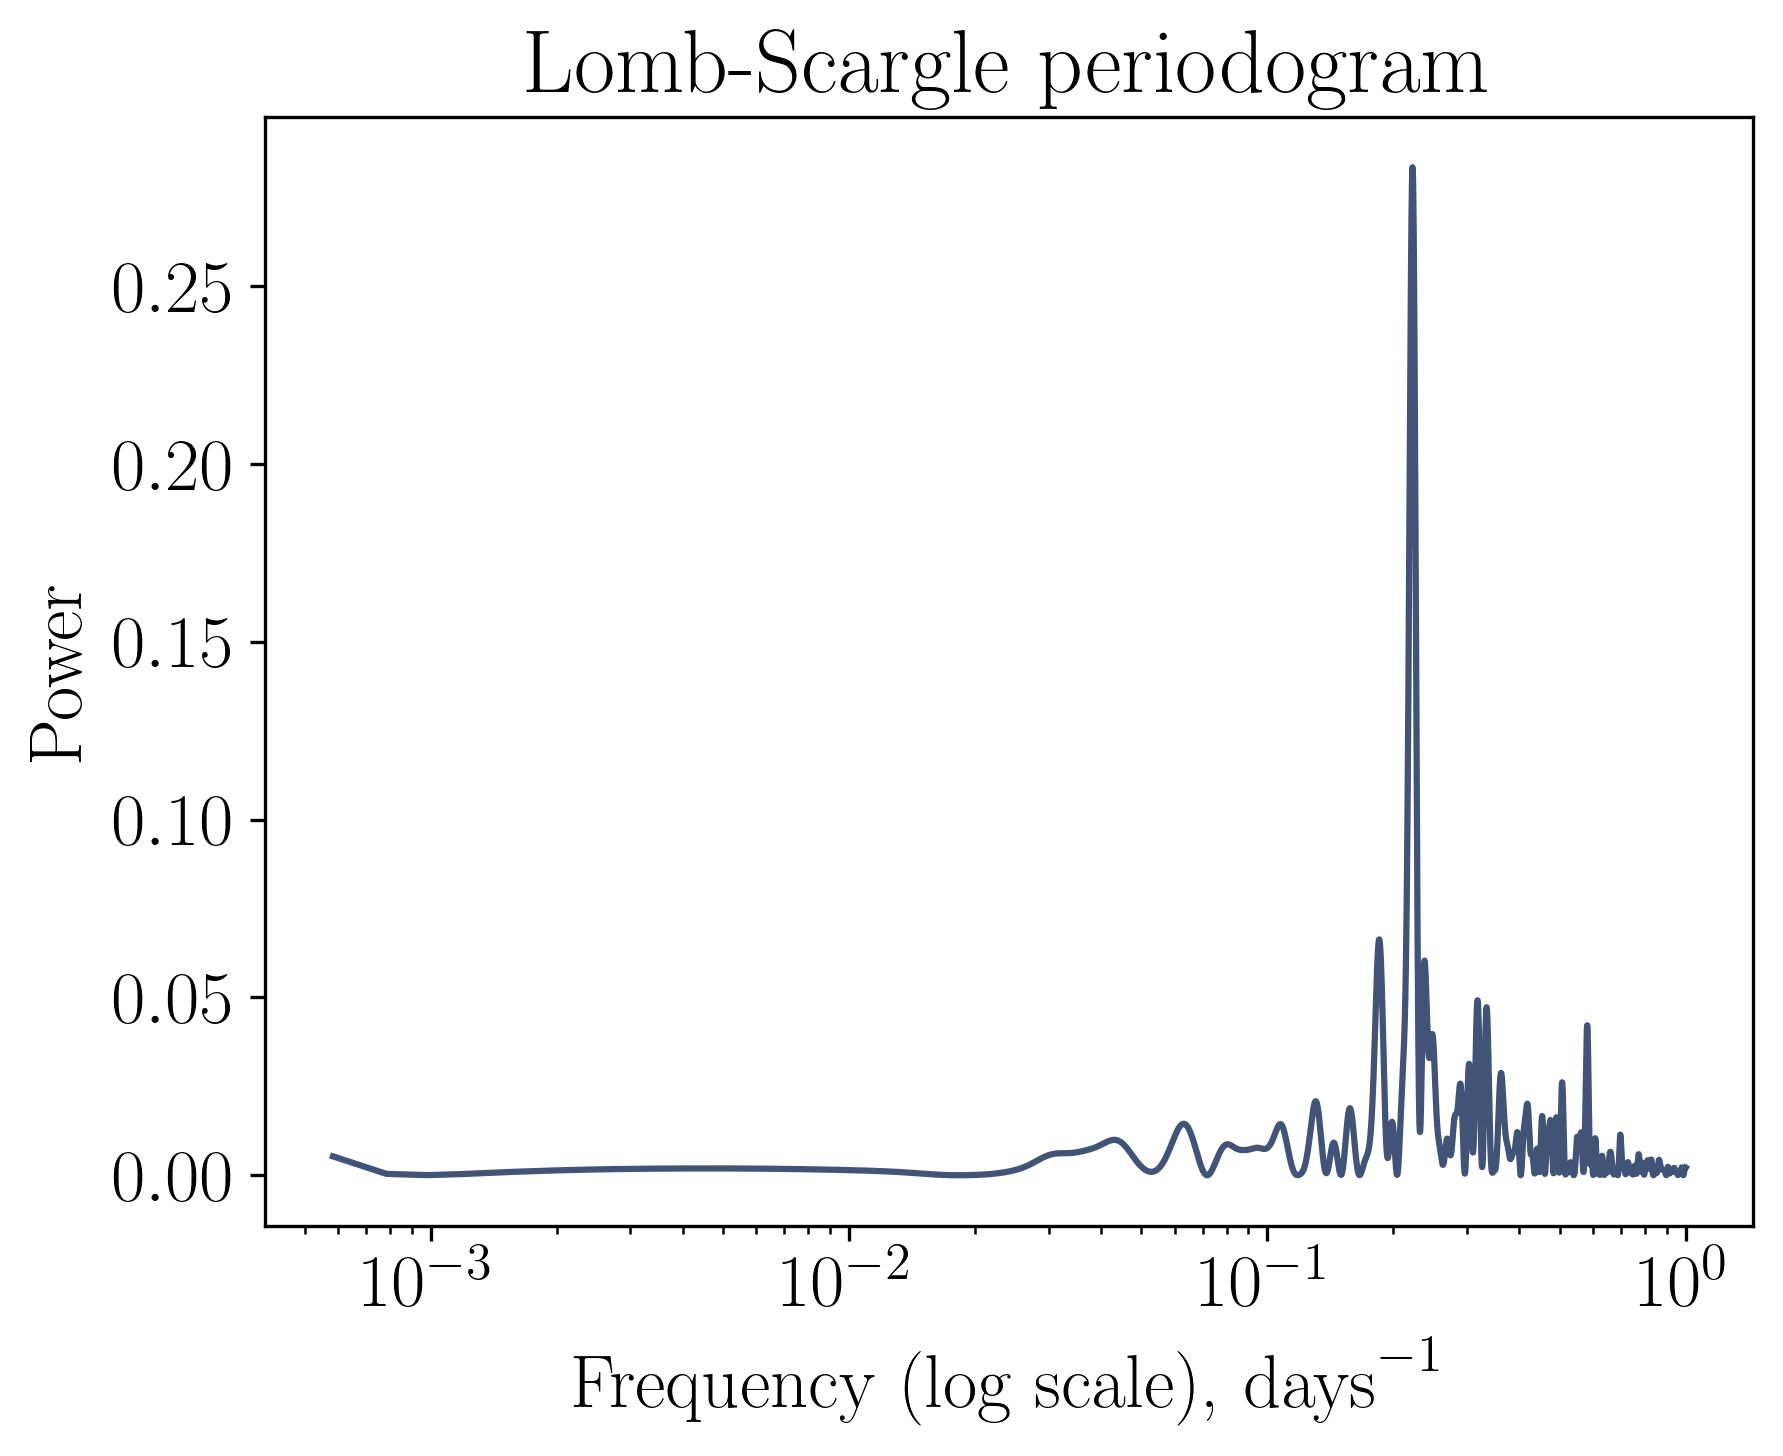

In [8]:
close()
plot(ν, P; color)

title(L"\textrm{Lomb-Scargle periodogram}")
xlabel(L"\textrm{Frequency (log scale), days}^{-1}")
ylabel(L"\textrm{Power}")
xscale("log")

In [9]:
close()